<a href="https://www.kaggle.com/code/eatmaass/recommendation-system?scriptVersionId=263030133" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831124 sha256=75944354d6120ed785f9427df1438fc99aa7dd12fd4fcec284500fef1a26c147
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm
Note: you may need to restart the kernel to use updated packages.


In [3]:
from lightfm import LightFM

model = LightFM()
print(" LightFM installed and ready!")


 LightFM installed and ready!


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os

# Define the path to the dataset
dataset_path = r"/kaggle/input/movielens"

# Load u.data (ratings data)
# Columns: user_id, item_id, rating, timestamp
u_data = pd.read_csv(os.path.join(dataset_path, "u.data"), 
                     sep='\t', 
                     names=['user_id', 'item_id', 'rating', 'timestamp'],
                     header=None)

# Load u.user (user information)
# Columns: user_id, age, gender, occupation, zip_code
u_user = pd.read_csv(os.path.join(dataset_path, "u.user"), 
                     sep='|', 
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
                     header=None)

# Load u.item (movie information)
# Columns: movie_id, title, release_date, video_release_date, imdb_url, and genre columns
item_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + \
               [f'genre_{i}' for i in range(19)]  # 19 genre columns

u_item = pd.read_csv(os.path.join(dataset_path, "u.item"), 
                     sep='|', 
                     names=item_columns,
                     header=None,
                     encoding='latin1')  # Handle special characters

# Load u.genre (genre information)
# Columns: genre, genre_id
u_genre = pd.read_csv(os.path.join(dataset_path, "u.genre"), 
                      sep='|', 
                      names=['genre', 'genre_id'],
                      header=None)

print("Dataset loaded successfully!")
print(f"u.data shape: {u_data.shape}")
print(f"u.user shape: {u_user.shape}")
print(f"u.item shape: {u_item.shape}")
print(f"u.genre shape: {u_genre.shape}")

Dataset loaded successfully!
u.data shape: (100000, 4)
u.user shape: (943, 5)
u.item shape: (1682, 24)
u.genre shape: (19, 2)


Creating visualizations for u.data (Ratings)...
Creating visualizations for u.user (Users)...
Creating visualizations for u.item (Movies)...
Creating combined analysis visualizations...


/tmp/ipykernel_37/343793773.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_avg = user_age_ratings.groupby('age_group')['rating'].mean()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


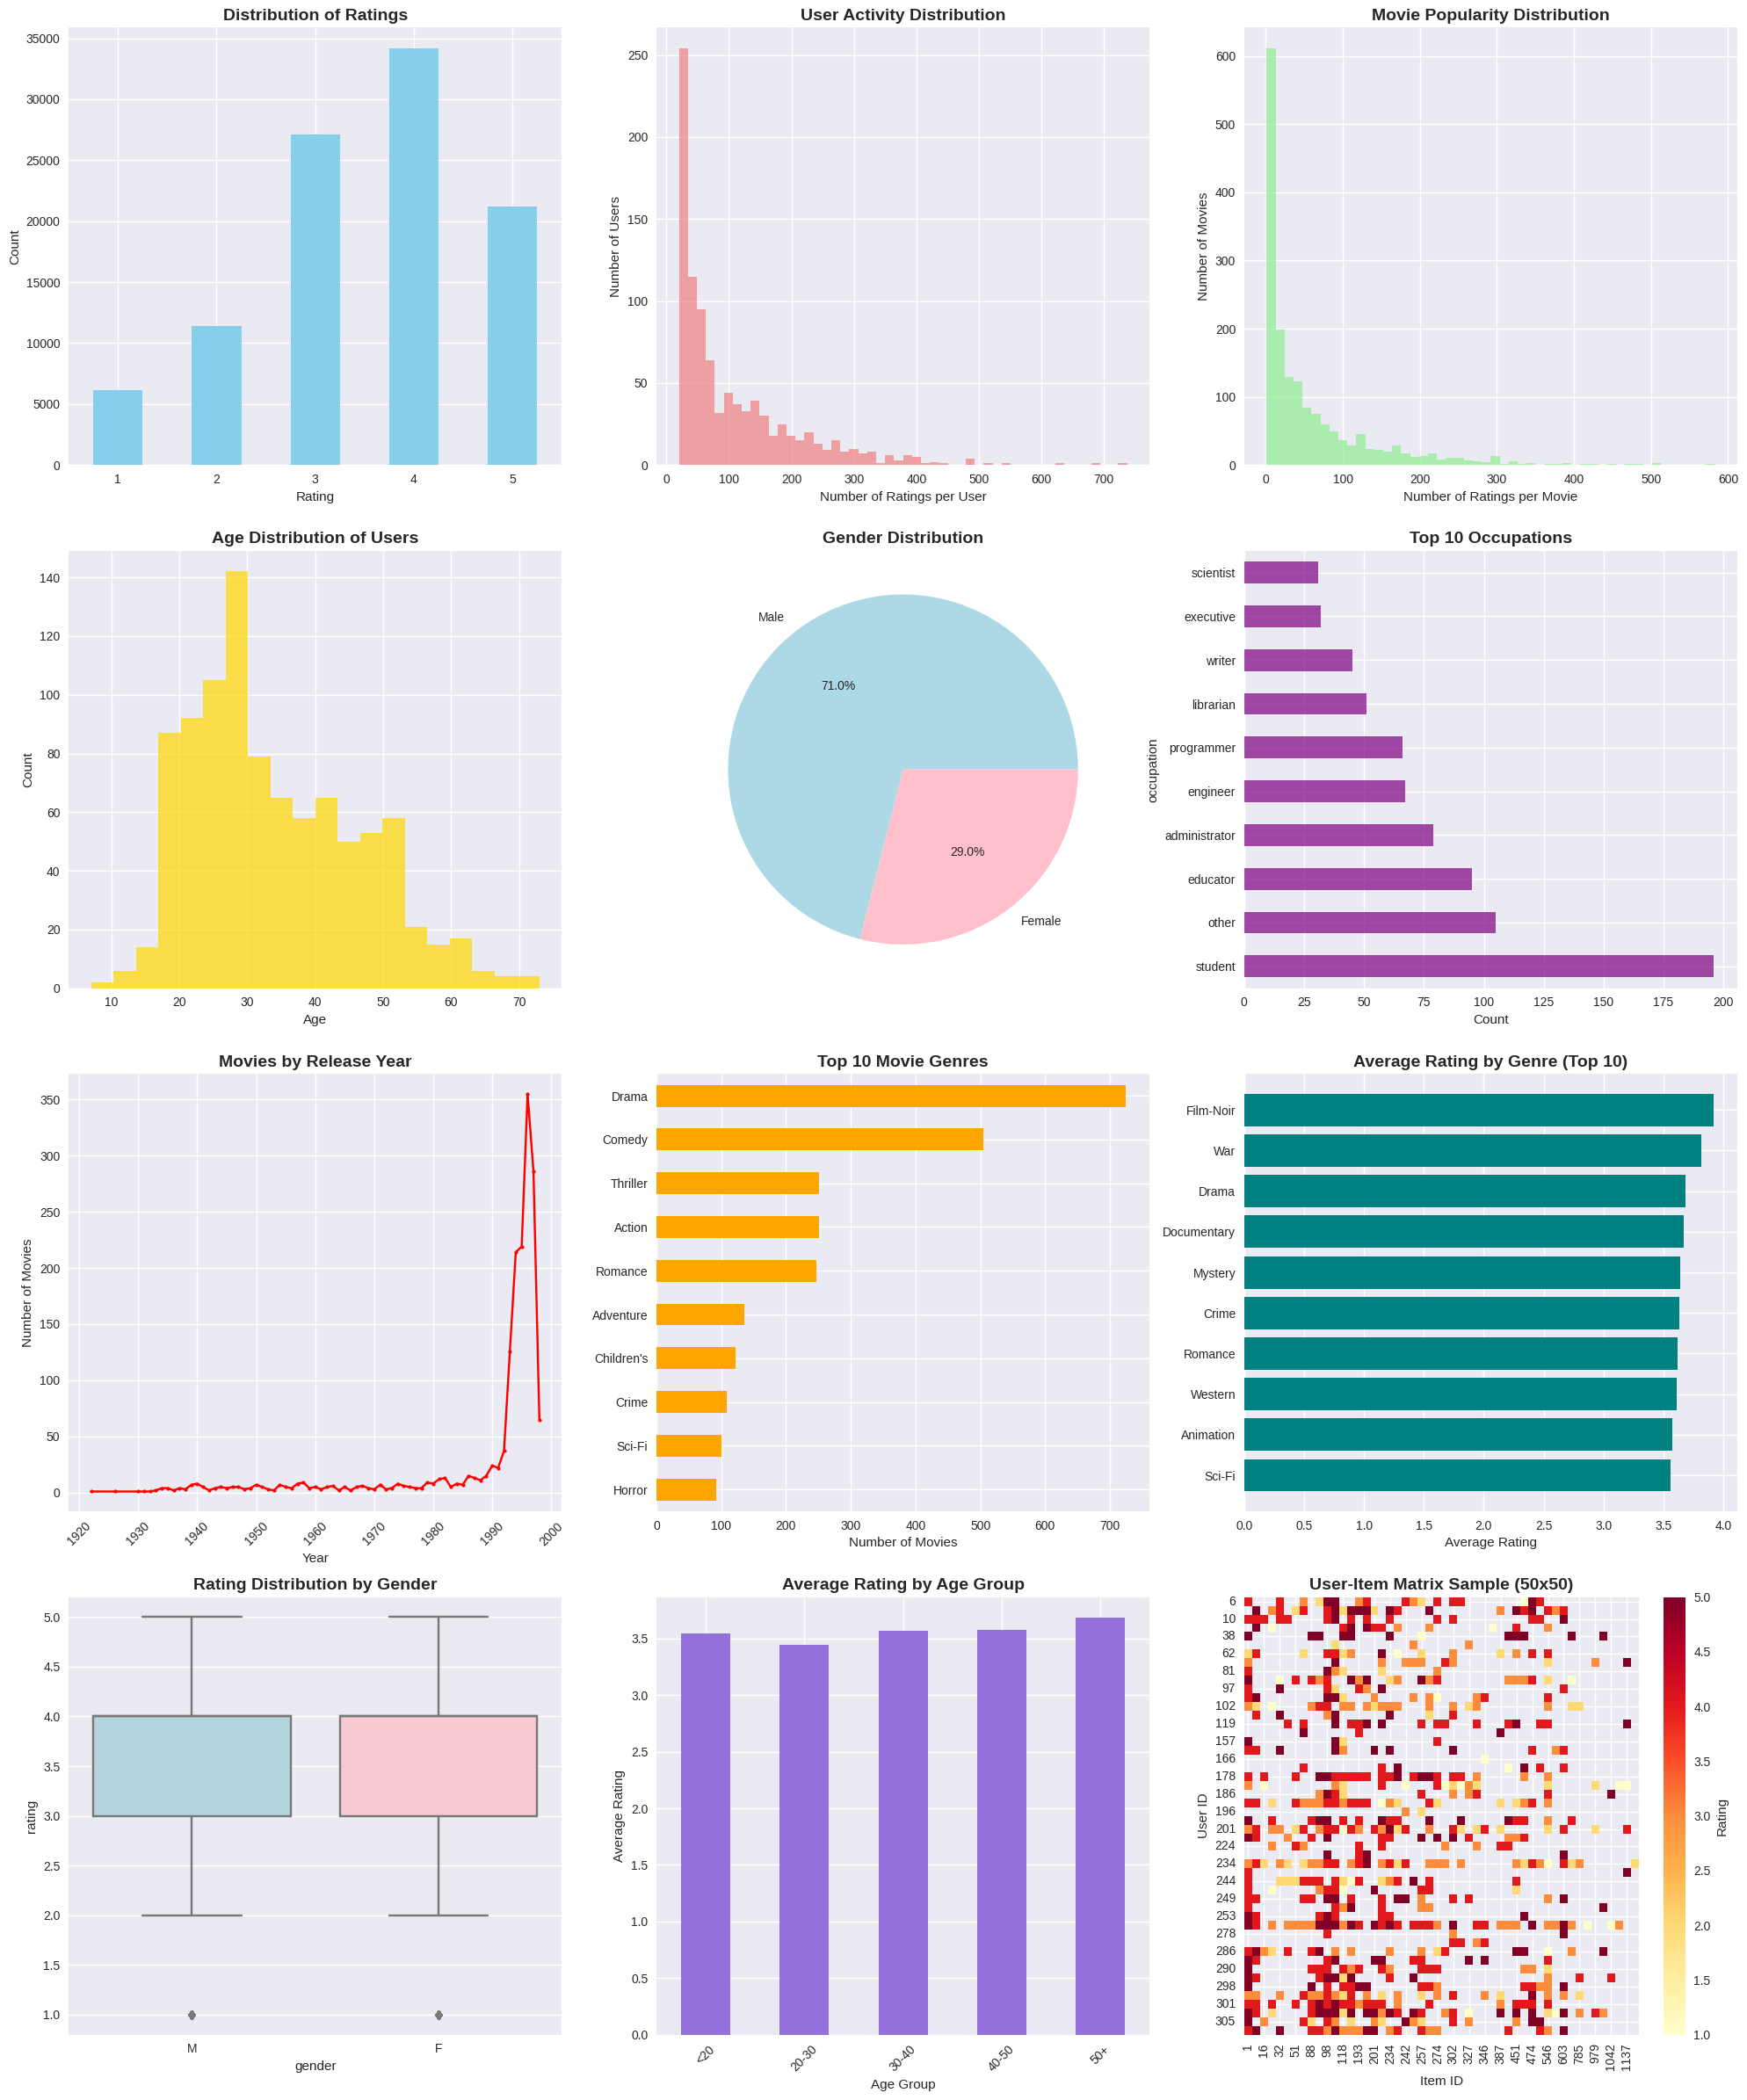


DATASET SUMMARY STATISTICS
Total ratings: 100,000
Total users: 943
Total movies: 1,682
Total genres: 19
Data sparsity: 93.70%
Average rating: 3.53
Rating std dev: 1.13
Most active user rated 737 movies
Most popular movie has 583 ratings


In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a large figure with subplots
fig = plt.figure(figsize=(20, 24))

# 1. RATINGS DATA VISUALIZATIONS
print("Creating visualizations for u.data (Ratings)...")

# Rating distribution
plt.subplot(4, 3, 1)
u_data['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)

# User activity (number of ratings per user)
plt.subplot(4, 3, 2)
user_ratings = u_data['user_id'].value_counts()
plt.hist(user_ratings, bins=50, color='lightcoral', alpha=0.7)
plt.title('User Activity Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')

# Movie popularity (number of ratings per movie)
plt.subplot(4, 3, 3)
movie_ratings = u_data['item_id'].value_counts()
plt.hist(movie_ratings, bins=50, color='lightgreen', alpha=0.7)
plt.title('Movie Popularity Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')

# 2. USER DATA VISUALIZATIONS
print("Creating visualizations for u.user (Users)...")

# Age distribution
plt.subplot(4, 3, 4)
plt.hist(u_user['age'], bins=20, color='gold', alpha=0.7)
plt.title('Age Distribution of Users', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Count')

# Gender distribution
plt.subplot(4, 3, 5)
gender_counts = u_user['gender'].value_counts()
plt.pie(gender_counts.values, labels=['Male', 'Female'], autopct='%1.1f%%', 
        colors=['lightblue', 'pink'])
plt.title('Gender Distribution', fontsize=14, fontweight='bold')

# Top occupations
plt.subplot(4, 3, 6)
top_occupations = u_user['occupation'].value_counts().head(10)
top_occupations.plot(kind='barh', color='purple', alpha=0.7)
plt.title('Top 10 Occupations', fontsize=14, fontweight='bold')
plt.xlabel('Count')

# 3. MOVIE DATA VISUALIZATIONS
print("Creating visualizations for u.item (Movies)...")

# Extract release years from u.item
u_item['release_year'] = pd.to_datetime(u_item['release_date'], format='%d-%b-%Y', errors='coerce').dt.year

# Movies by release year
plt.subplot(4, 3, 7)
year_counts = u_item['release_year'].value_counts().sort_index()
year_counts.plot(kind='line', color='red', marker='o', markersize=3)
plt.title('Movies by Release Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# Genre popularity (sum of all genre columns)
plt.subplot(4, 3, 8)
genre_cols = [col for col in u_item.columns if col.startswith('genre_')]
genre_sums = u_item[genre_cols].sum()
genre_names = u_genre['genre'].tolist()
genre_popularity = pd.Series(genre_sums.values, index=genre_names)
genre_popularity.sort_values(ascending=True).tail(10).plot(kind='barh', color='orange')
plt.title('Top 10 Movie Genres', fontsize=14, fontweight='bold')
plt.xlabel('Number of Movies')

# 4. COMBINED ANALYSIS
print("Creating combined analysis visualizations...")

# Average rating by genre
plt.subplot(4, 3, 9)
# Merge data to get ratings with genres
merged_data = u_data.merge(u_item[['movie_id'] + genre_cols], left_on='item_id', right_on='movie_id')
genre_ratings = []
for i, genre in enumerate(genre_names):
    genre_col = f'genre_{i}'
    if genre_col in merged_data.columns:
        genre_movies = merged_data[merged_data[genre_col] == 1]
        if len(genre_movies) > 0:
            avg_rating = genre_movies['rating'].mean()
            genre_ratings.append((genre, avg_rating))

genre_ratings_df = pd.DataFrame(genre_ratings, columns=['genre', 'avg_rating'])
genre_ratings_df = genre_ratings_df.sort_values('avg_rating', ascending=True).tail(10)
plt.barh(genre_ratings_df['genre'], genre_ratings_df['avg_rating'], color='teal')
plt.title('Average Rating by Genre (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating')

# Rating distribution by gender
plt.subplot(4, 3, 10)
user_gender_ratings = u_data.merge(u_user[['user_id', 'gender']], on='user_id')
sns.boxplot(data=user_gender_ratings, x='gender', y='rating', palette=['lightblue', 'pink'])
plt.title('Rating Distribution by Gender', fontsize=14, fontweight='bold')

# Average rating by age group
plt.subplot(4, 3, 11)
u_user['age_group'] = pd.cut(u_user['age'], bins=[0, 20, 30, 40, 50, 100], 
                            labels=['<20', '20-30', '30-40', '40-50', '50+'])
user_age_ratings = u_data.merge(u_user[['user_id', 'age_group']], on='user_id')
age_group_avg = user_age_ratings.groupby('age_group')['rating'].mean()
age_group_avg.plot(kind='bar', color='mediumpurple')
plt.title('Average Rating by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# Sparsity visualization (sample)
plt.subplot(4, 3, 12)
# Create a small sample of the user-item matrix for visualization
sample_users = u_data['user_id'].unique()[:50]
sample_items = u_data['item_id'].unique()[:50]
sample_data = u_data[u_data['user_id'].isin(sample_users) & u_data['item_id'].isin(sample_items)]

# Create pivot table
pivot_sample = sample_data.pivot_table(index='user_id', columns='item_id', values='rating')
sns.heatmap(pivot_sample, cmap='YlOrRd', cbar_kws={'label': 'Rating'})
plt.title('User-Item Matrix Sample (50x50)', fontsize=14, fontweight='bold')
plt.xlabel('Item ID')
plt.ylabel('User ID')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"Total ratings: {len(u_data):,}")
print(f"Total users: {len(u_user):,}")
print(f"Total movies: {len(u_item):,}")
print(f"Total genres: {len(u_genre):,}")
print(f"Data sparsity: {(1 - len(u_data) / (len(u_user) * len(u_item))) * 100:.2f}%")
print(f"Average rating: {u_data['rating'].mean():.2f}")
print(f"Rating std dev: {u_data['rating'].std():.2f}")
print(f"Most active user rated {user_ratings.max()} movies")
print(f"Most popular movie has {movie_ratings.max()} ratings")

In [4]:
# MERGE ALL DATASETS INTO ONE COMPREHENSIVE TABLE
print("Merging  datasets ")

# Step 1: Start with the ratings data (u.data) as the base
merged_df = u_data.copy()
print(f"Base table (u.data) shape: {merged_df.shape}")

# Step 2: Add user information
merged_df = merged_df.merge(u_user, on='user_id', how='left')


# Step 3: Add movie information (merge on item_id = movie_id)
merged_df = merged_df.merge(u_item, left_on='item_id', right_on='movie_id', how='left')


# Step 4: Convert timestamp to readable datetime
merged_df['rating_datetime'] = pd.to_datetime(merged_df['timestamp'], unit='s')

# Step 5: Create genre names columns (instead of just 0/1)
print("Adding genre information...")
genre_names = u_genre['genre'].tolist()

# Create a list of genres for each movie
def get_movie_genres(row):
    genres = []
    for i, genre in enumerate(genre_names):
        if row[f'genre_{i}'] == 1:
            genres.append(genre)
    return ', '.join(genres) if genres else 'No Genre'

merged_df['genres'] = merged_df.apply(get_movie_genres, axis=1)

# Step 6: Add some useful calculated columns
# merged_df['is_high_rating'] = merged_df['rating'] >= 4
# merged_df['is_low_rating'] = merged_df['rating'] <= 2

# Clean up movie title (remove year from title and put in separate column)
merged_df['title_clean'] = merged_df['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)
merged_df['title_year'] = merged_df['title'].str.extract(r'\((\d{4})\)$')[0]

# Step 7: Remove unwanted columns
print("Removing unwanted columns: zip_code, release_date, video_release_date, title...")
columns_to_remove = ['zip_code', 'release_date', 'video_release_date', 'title','imdb_url']
existing_columns_to_remove = [col for col in columns_to_remove if col in merged_df.columns]
if existing_columns_to_remove:
    merged_df = merged_df.drop(columns=existing_columns_to_remove)
    print(f"Removed columns: {existing_columns_to_remove}")
else:
    print("No matching columns found to remove")


available_columns = merged_df.columns.tolist()

preferred_order = [
    # Rating info
    'user_id', 'item_id', 'rating', 'is_high_rating', 'is_low_rating',
    'rating_datetime',  'timestamp',
    
    # User info (removed zip_code)
    'age', 'gender', 'occupation',
    
    # Movie info (removed title, release_date, video_release_date)
    'movie_id', 'title_clean', 'title_year',
    'genres'
]

# Add genre columns
genre_columns = [col for col in merged_df.columns if col.startswith('genre_')]
preferred_order.extend(genre_columns)

# Only use columns that actually exist
column_order = [col for col in preferred_order if col in available_columns]

# Add any remaining columns
remaining_cols = [col for col in available_columns if col not in column_order]
column_order.extend(remaining_cols)

# Reorder columns
merged_df = merged_df[column_order]

# Display information about the merged dataset

print("MERGED DATASET INFORMATION")
print("\n\n")
print(f"Final merged table shape: {merged_df.shape}")
print(f"Columns: {len(merged_df.columns)}")
print(f"Total records: {len(merged_df):,}")

print(f"\nColumn names:")
for i, col in enumerate(merged_df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nData types:")
print(merged_df.dtypes.value_counts())

print(f"\nMemory usage: {merged_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


# Save the merged dataset
output_path = "/kaggle/working/movie_data.csv"
merged_df.to_csv(output_path, index=False)
print(f"Merged dataset saved to: {output_path}")


print("done!")

Merging  datasets 
Base table (u.data) shape: (100000, 4)
Adding genre information...
Removing unwanted columns: zip_code, release_date, video_release_date, title...
Removed columns: ['zip_code', 'release_date', 'video_release_date', 'title', 'imdb_url']
MERGED DATASET INFORMATION



Final merged table shape: (100000, 33)
Columns: 33
Total records: 100,000

Column names:
 1. user_id
 2. item_id
 3. rating
 4. rating_datetime
 5. timestamp
 6. age
 7. gender
 8. occupation
 9. movie_id
10. title_clean
11. title_year
12. genres
13. genre_0
14. genre_1
15. genre_2
16. genre_3
17. genre_4
18. genre_5
19. genre_6
20. genre_7
21. genre_8
22. genre_9
23. genre_10
24. genre_11
25. genre_12
26. genre_13
27. genre_14
28. genre_15
29. genre_16
30. genre_17
31. genre_18
32. age_group
33. release_year

Data types:
int64             25
object             5
datetime64[ns]     1
category           1
float64            1
Name: count, dtype: int64

Memory usage: 52.15 MB
Merged dataset saved to: /kaggle

In [6]:
ds=pd.read_csv(r"/kaggle/working/movie_data.csv")

In [13]:
print(ds)

       user_id  item_id  rating      rating_datetime  timestamp  age gender  \
0          196      242       3  1997-12-04 15:55:49  881250949   49      M   
1          186      302       3  1998-04-04 19:22:22  891717742   39      F   
2           22      377       1  1997-11-07 07:18:36  878887116   25      M   
3          244       51       2  1997-11-27 05:02:03  880606923   28      M   
4          166      346       1  1998-02-02 05:33:16  886397596   47      M   
...        ...      ...     ...                  ...        ...  ...    ...   
99995      880      476       3  1997-11-22 05:10:44  880175444   13      M   
99996      716      204       5  1997-11-17 19:39:03  879795543   36      F   
99997      276     1090       1  1997-09-20 22:49:55  874795795   21      M   
99998       13      225       2  1997-12-17 22:52:36  882399156   47      M   
99999       12      203       3  1997-11-19 17:13:03  879959583   28      F   

          occupation  movie_id            title_cle